In [204]:
import numpy as np
from dataclasses import dataclass
from itertools import product
import matplotlib.pyplot as plt
from copy import deepcopy
import os
import subprocess


@dataclass
class Atom:
    r: np.ndarray
    p: np.ndarray


class Variables:
    def __init__(self):
        self.atoms = []

    def add_atoms(self, r):
        a = Atom(r, np.array([0, 0, 0]))
        self.atoms.append(a)

    def num_atoms(self):
        return len(self.atoms)


class Observer:
    def __init__(self, vars, sigma):
        self.vars = vars
        self.sigma12 = sigma**12
        self.sigma6 = sigma**6

    def kinetic_energy(self):
        ke = 0
        for a in self.vars.atoms:
            ke += 0.5 * np.linalg.norm(a.p) ** 2
        return ke / self.vars.num_atoms()

    def potential_energy(self):
        num_atoms = self.vars.num_atoms()
        pe = 0
        for i in range(num_atoms):
            for j in range(i + 1, num_atoms):
                a = self.vars.atoms[i]
                b = self.vars.atoms[j]
                r = a.r - b.r
                r2 = np.linalg.norm(r) ** 2
                pe += 4 * (self.sigma12 / r2**6 - self.sigma6 / r2**3)
        return pe / self.vars.num_atoms()


class MD:
    def __init__(self, L, a, T, dt, nstep, sigma):
        self.L = L
        self.a = a
        self.T = T
        self.dt = dt
        self.nstep = nstep
        self.energy = []
        self.sigma = sigma
        self.sigma12 = sigma**12
        self.sigma6 = sigma**6

    def initial_position(self, vars):
        for ix, iy, iz in product(range(self.L), repeat=3):
            r = self.a * np.array([ix, iy, iz])
            vars.add_atoms(r)
        for ix, iy, iz in product(range(self.L), repeat=3):
            r = self.a * np.array([ix, iy + 0.5, iz + 0.5])
            vars.add_atoms(r)
        for ix, iy, iz in product(range(self.L), repeat=3):
            r = self.a * np.array([ix + 0.5, iy, iz + 0.5])
            vars.add_atoms(r)
        for ix, iy, iz in product(range(self.L), repeat=3):
            r = self.a * np.array([ix + 0.5, iy + 0.5, iz])
            vars.add_atoms(r)
        return vars

    def initial_position2(self, vars):
        vars.add_atoms(self.a * np.array([0, 0, 0.1]))
        vars.add_atoms(self.a * np.array([0.5, 0, 0]))
        vars.add_atoms(self.a * np.array([0, 0, 0.9]))
        vars.add_atoms(self.a * np.array([0.5, 0, 1]))
        return vars

    def add_initial_momentum(self, vars):
        for a in vars.atoms:
            a.p = np.random.normal(0, np.sqrt(self.T), 3)

    def add_initial_momentum_2(self, vars):
        vars.atoms[0].p = np.array([10, 0, 0])
        vars.atoms[1].p = np.array([-10, 0, 0])
        vars.atoms[2].p = np.array([10, 0, 0])
        vars.atoms[3].p = np.array([-10, 0, 0])

    def makeconf(self, vars):
        vars = self.initial_position(vars)
        self.add_initial_momentum(vars)
        # vars = self.initial_position2(vars)
        # self.add_initial_momentum_2(vars)
        return vars

    def adjust_periodic(self, r):
        for i in range(3):
            if r[i] > self.L * self.a / 2:
                r[i] -= self.L * self.a
            if r[i] < -self.L * self.a / 2:
                r[i] += self.L * self.a
        return r

    def update_position_first(self, vars0):
        vars1 = deepcopy(vars0)
        pn = vars0.num_atoms()
        for i in range(pn):
            a0 = vars0.atoms[i]
            a1 = vars1.atoms[i]
            a1.r = a0.r + a0.p * self.dt
        return vars1

    def update_position(self, vars0, vars1, f):
        vars2 = deepcopy(vars1)
        pn = vars0.num_atoms()
        for i in range(pn):
            a0 = vars0.atoms[i]
            a1 = vars1.atoms[i]
            a2 = vars2.atoms[i]
            a2.r = 2 * a1.r - a0.r + f[i] * self.dt**2
            # a2.r = a1.r + a1.p * self.dt
        return vars2

    def calcualte_force(self, vars1):
        pn = vars1.num_atoms()
        # f = np.zeros((pn, 3))
        f = [np.array([0, 0, 0]) for _ in range(pn)]
        for i in range(pn):
            for j in range(i + 1, pn):
                a1 = vars1.atoms[i]
                b1 = vars1.atoms[j]
                r = a1.r - b1.r
                r = self.adjust_periodic(r)
                r2 = np.linalg.norm(r) ** 2
                f[i] = f[i] + 24 * (2 * self.sigma12 / r2**7 - self.sigma6 / r2**4) * r
                f[j] = f[j] - 24 * (2 * self.sigma12 / r2**7 - self.sigma6 / r2**4) * r
        return f

    def update_momentum(self, vars0, vars2, f):
        pn = vars0.num_atoms()
        for i in range(pn):
            a0 = vars0.atoms[i]
            a2 = vars2.atoms[i]
            a2.p = a0.p + 2 * self.dt * f[i]

    def periodic(self, vars):
        box_size = self.L * self.a
        for a in vars.atoms:
            a.r = np.mod(a.r, box_size)  # NumPy の mod 関数を使用して周期境界条件を適用

    def dump_trajectory(self, atoms):
        with open(f"trajectory.xyz", "a") as f:
            f.write(f"{len(atoms)}\n")
            f.write("\n")
            for a in atoms:
                f.write(f"Ar {a.r[0]} {a.r[1]} {a.r[2]}\n")

    def run(self):
        subprocess.run(["rm", "trajectory.xyz"])
        vars0 = Variables()
        vars0 = self.makeconf(vars0)
        vars1 = self.update_position_first(vars0)
        self.dump_trajectory(vars1.atoms)
        for i in range(self.nstep):
            f = self.calcualte_force(vars1)
            vars2 = self.update_position(vars0, vars1, f)
            self.update_momentum(vars0, vars2, f)
            self.periodic(vars2)
            obs = Observer(vars2, self.sigma)
            self.energy.append([obs.kinetic_energy(), obs.potential_energy()])
            self.dump_trajectory(vars2.atoms)
            vars0 = deepcopy(vars1)
            vars1 = deepcopy(vars2)

In [205]:
params = {"L": 2, "a": 10, "T": 10, "dt": 0.01, "nstep": 1000, "sigma": 1}
md = MD(**params)
md.run()

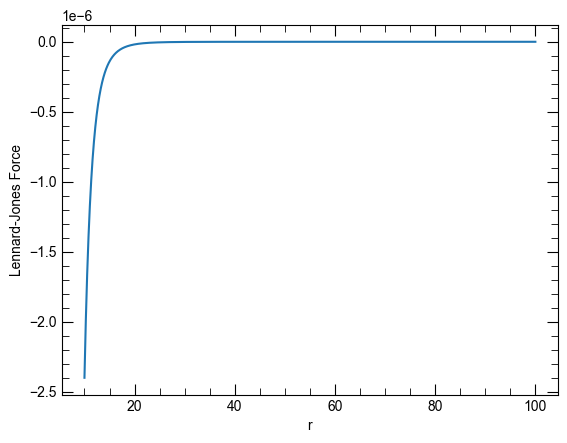

In [206]:
sigma = params["sigma"]
sigma12 = sigma**12
sigma6 = sigma**6
r = np.linspace(10, 100, 1000)
lj_force = 24 * (2 * sigma12 / r**13 - sigma6 / r**7)
fig, ax = plt.subplots()
ax.plot(r, lj_force)
ax.set_xlabel("r")
ax.set_ylabel("Lennard-Jones Force")
plt.show()

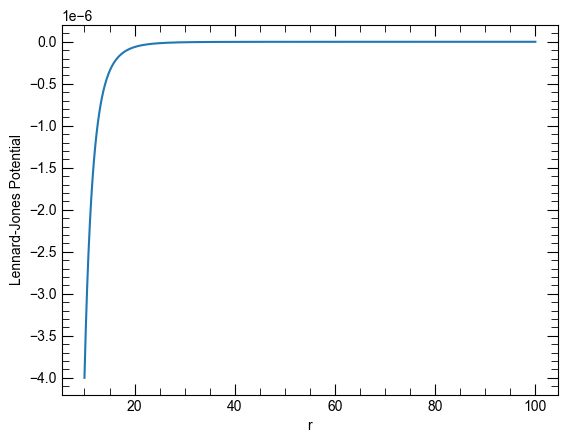

In [207]:
lj_potential = 4 * (1 / r**12 - 1 / r**6)
fig, ax = plt.subplots()
ax.plot(r, lj_potential)
ax.set_xlabel("r")
ax.set_ylabel("Lennard-Jones Potential")
plt.show()

In [208]:
md.energy

[[15.537632561723573, -0.00010287801082019794],
 [15.537632957065703, -0.00010396773508072601],
 [15.537634236832979, -0.00010519384351399764],
 [15.537635049535762, -0.00010656354779294405],
 [15.537636760723919, -0.00010808495638219215],
 [15.53763802106327, -0.00010976714048033569],
 [15.53764019836999, -0.00011162020794354211],
 [15.537641945702896, -0.00011365538636649644],
 [15.53764463341643, -0.0001158851167680176],
 [15.53764691727165, -0.00011832315966828929],
 [15.537650170512032, -0.00012098471576885938],
 [15.537653051998701, -0.0001238865639732836],
 [15.537656938317264, -0.00012704722013440214],
 [15.53766049194763, -0.00013048712070247066],
 [15.537665093416452, -0.00013422883639395444],
 [15.537669409520182, -0.00013829732211757709],
 [15.537674825547914, -0.00014272021069052857],
 [15.537680013588583, -0.00014752815935425832],
 [15.537686364863687, -0.00015275525974717366],
 [15.537692558166473, -0.00015843952379155523],
 [15.537699992362963, -0.00016462345987517884],

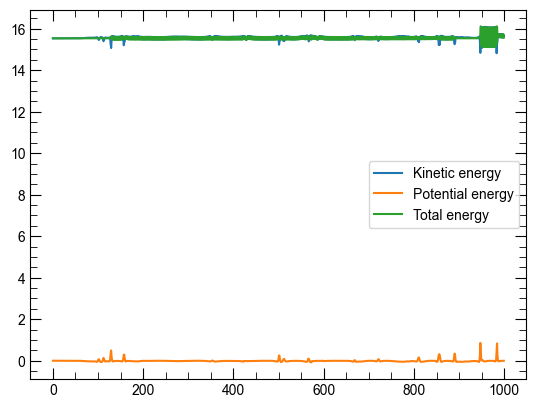

In [210]:
fig, ax = plt.subplots()
ax.plot([e[0] for e in md.energy], label="Kinetic energy")
ax.plot([e[1] for e in md.energy], label="Potential energy")
ax.plot([e[0] + e[1] for e in md.energy], label="Total energy")
ax.legend()
# ax.set_ylim(-10, 1000)
plt.show()